# MNIST digits classification with PyTorch

In this programming assignment you will implement your first neural network and train it to classify handwritten digits.

In [6]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import tqdm
import itertools
import collections
from IPython import display

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

In [7]:
#auxiliary stuff
class AverageMeter:
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## MNIST dataset

In this task we will work with MNIST dataset which contains 60000 28x28 images of handwritten digits from 0 to 9. 

For the data processing we'll use `torchvision` library. It is very simple and easy to use library for computer vision & deep learning. For a deep dive into the library you can check out the githab page: https://github.com/pytorch/vision

Firstly, we set up datasets and dataloaders:

In [10]:
# use it to conver from PIL to torch.Tensor
image_transform = ToTensor()

train_dataset = MNIST(root='./', train=True, download=True, transform=image_transform)
test_dataset = MNIST(root='./', train=False, download=True, transform=image_transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [11]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
)

Let's look at a batch of images:

Labels of images:  [[8, 7, 6, 7, 1, 0, 8, 0], [4, 7, 2, 1, 4, 3, 5, 0], [7, 3, 3, 6, 2, 0, 8, 3], [2, 2, 1, 6, 9, 1, 9, 9]]


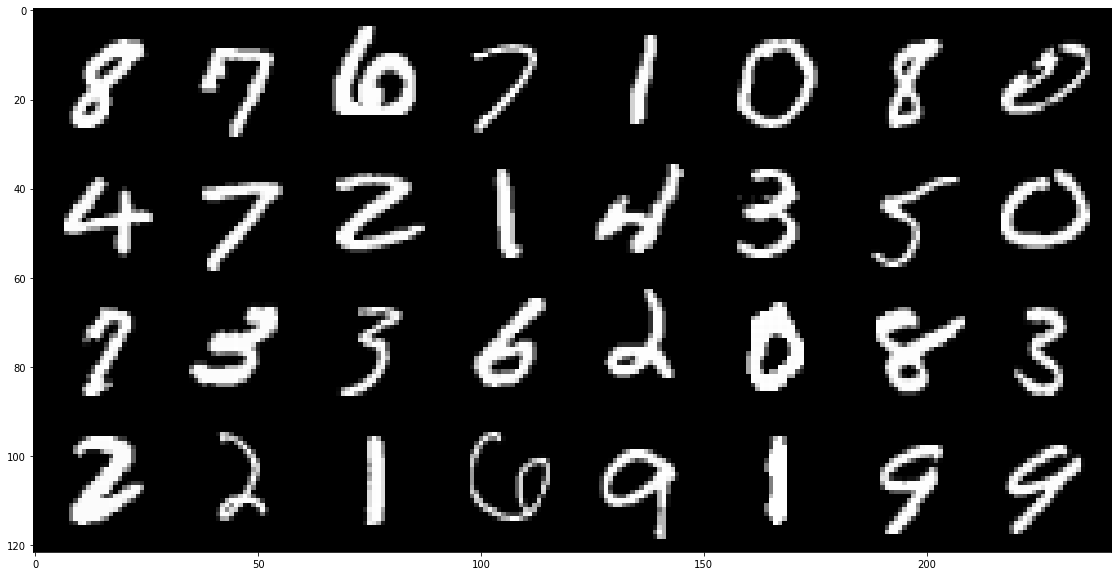

In [12]:
example_batch = list(itertools.islice(train_dataloader, 1))[0]
images, labels = example_batch

# make a grid of images
grid_images = make_grid(images, 8).permute(1, 2, 0)

print("Labels of images: ", labels.view(-1, 8).tolist())

plt.figure(figsize=(20, 10))
plt.imshow(make_grid(images, 8).permute(1, 2, 0))

The task is to train a model that will be able to take an image as an input and predict the class label for it (from 0 to 9) as an output.

As a main metric we will use accuracy:

In [13]:
def calculate_accuracy(prediction, target):
    # Note that prediction.shape == target.shape == [B, ]
    
    matching = (prediction == target).float()
    return matching.mean()

## Linear Model

Let's start with a linear model and implement it as a neural network in PyTorch. 

Linear model takes a batch of $B$ images as an input, applies a linear transformation to them and outputs logits. For each image $x$ it returns a vector of logits $z$:
$$z = x \cdot W + b $$

Here x.shape = [1, 28 * 28], z.shape = [1, 10].

Then, we can make the prediction $\hat{y}$ for $x$ by taking the class with the maximum logit or obtain probabilities $p$ for all classes by applying softmax function to vector of logits:
$$\hat{y} = \arg\max_k z_k \quad p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$


In [14]:
# Any neural network in PyTorch is a class with trainable (i.e. requires_grad=True) parameters.
# For more detailed tutorial look at https://pytorch.org/tutorials/beginner/nn_tutorial.html

class LinearModel(nn.Module):  # inheritance from nn.Module is required
    
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()  # don't forget to init subclass
        
        # initialize weight and bias
        # NOTE that using of nn.Parameter is required
        # Don't use just torch.Tensor
        self.weight = nn.Parameter(torch.randn(output_dim, input_dim))
        self.bias = nn.Parameter(torch.zeros(output_dim))
        
        # initialize weight correctly
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.kaiming_normal_(self.weight)
    
    def forward(self, input: torch.Tensor):
        # We expect input.shape == [B, 1, 28, 28] and need to output logits.shape = [B,10]
        
        ### YOUR SOLUTION ###
        logits = input.reshape(input.shape[0], -1) @ self.weight.T + self.bias
        return logits

In [15]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10  # num classes

linear_model = LinearModel(INPUT_DIM, OUTPUT_DIM)

In [16]:
# validate shapes

assert linear_model.weight.shape == (OUTPUT_DIM, INPUT_DIM)
assert linear_model.bias.shape == (OUTPUT_DIM, )
assert linear_model.forward(example_batch[0]).shape == (BATCH_SIZE, 10)

To train the model we will need a loss and an optimizer. 

We will use a cross-entropy loss, for one object it looks as follows:
$$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$ 

where $y$ is a true label, $p_k$ is a predicted probability for class $k$, and  
$$
[x]=\begin{cases}
       1, \quad \text{if $x$ is true} \\
       0, \quad \text{otherwise}
    \end{cases}
$$

Cross-entropy minimization pushes $p_k$ close to 1 when $y = k$, which is what we want.

CrossEntropyLoss criterion in PyTorch combines softmax and loss calculation.

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2, momentum=0.9, nesterov=True)

Write training and testing loops

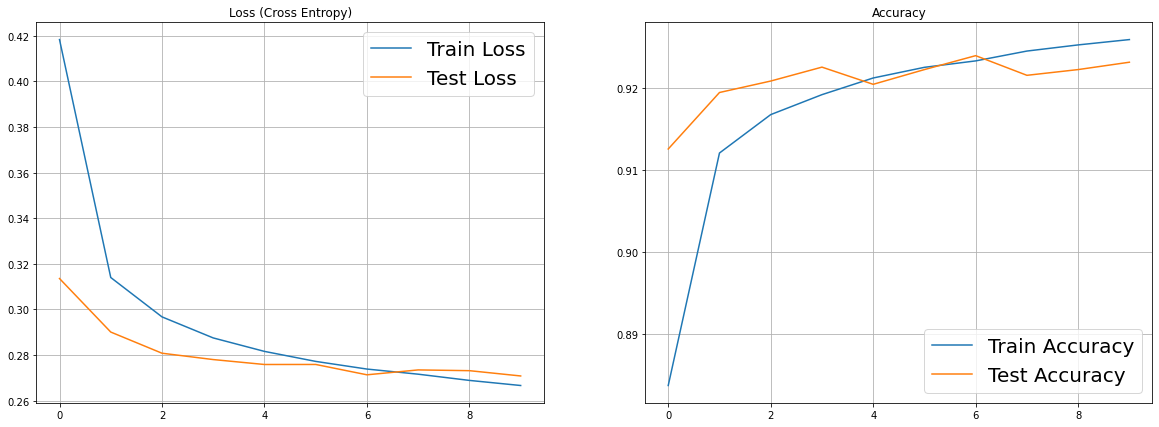

In [18]:
NUM_EPOCH = 10
DEVICE = torch.device('cpu')  # you can change to `cuda:0`
HISTORY = collections.defaultdict(list)

linear_model.to(DEVICE)

for epoch in range(NUM_EPOCH):
    # AverageMeter will accumulate average of some metric
    # Procceed to `utils.py` to see implementation
    train_loss_meter = AverageMeter()
    train_accuracy_meter = AverageMeter()
    test_loss_meter = AverageMeter()
    test_accuracy_meter = AverageMeter()
    
    # training loop
    for train_batch in train_dataloader:
        
        # unpack batch and move to specific device (for example, GPU or TPU)
        images, labels = train_batch
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        ### YOUR SOLUTION ###
        # do forward pass
        # calculate loss (CrossEntropy)
        # zero out the previous gradients of our model parameters
        # calculate new gradients
        # do optimization step
        optimizer.zero_grad()
        logits = linear_model(images)
        prediction = logits.argmax(dim=-1)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        # calculate current average loss and accuracy
        train_loss_meter.update(loss.item())
        train_accuracy_meter.update(
            calculate_accuracy(
                prediction.detach(),
                labels
            ).item()
        )
        
    # save average train loss and accuracy
    HISTORY['train_loss'].append(train_loss_meter.avg)
    HISTORY['train_accuracy'].append(train_accuracy_meter.avg)
        
    # testing loop
    for test_batch in test_dataloader:
        images, labels = test_batch
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # аdd `with torch.no_grad()' to avoid computing gradients of weights
        with torch.no_grad():
            # do everything like we did in training loop
            logits = linear_model(images)
            prediction = logits.argmax(dim=-1)
            loss = criterion(logits, labels)
        
        test_loss_meter.update(loss.item())
        test_accuracy_meter.update(
            calculate_accuracy(
                prediction,
                labels
            ).item()
        )
    
    # save average test accuracy loss and accuracy
    HISTORY['test_loss'].append(test_loss_meter.avg)
    HISTORY['test_accuracy'].append(test_accuracy_meter.avg)
    
    # visualize all together
    display.clear_output()
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))
    axes[0].set_title('Loss (Cross Entropy)')
    axes[0].plot(HISTORY['train_loss'], label='Train Loss')
    axes[0].plot(HISTORY['test_loss'], label='Test Loss')
    axes[0].grid()
    axes[0].legend(fontsize=20)
    
    axes[1].set_title('Accuracy')
    axes[1].plot(HISTORY['train_accuracy'], label='Train Accuracy')
    axes[1].plot(HISTORY['test_accuracy'], label='Test Accuracy')
    axes[1].grid()
    axes[1].legend(fontsize=20)
    
    plt.show()

In [19]:
assert HISTORY['test_accuracy'][-1] > 0.92

In [20]:
ans_part1 = HISTORY['test_accuracy'][-1]

## MLP with hidden layers

Previously we've coded a fully-connected linear layer with matrix multiplication by hand. But usually people code only very specific layers by hand, all standard layers are already implemented in PyTorch. The analog of our LinearModel in PyTorch is nn.Linear

Now define an MLP with 2 hidden layers. 
- Do not forget to use nonlinearities between linear layers, for example, nn.ReLU
- nn.Sequential help you to combine several layers into one model 

In [23]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10  # num classes

# HINT
# Use nn.Sequential, nn.Linear and nn.ReLU

### YOUR SOLUTION ###
mlp_model = nn.Sequential(nn.Linear(INPUT_DIM, INPUT_DIM), nn.ReLU(), nn.Linear(INPUT_DIM, OUTPUT_DIM))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mlp_model.parameters(), lr=1e-2, momentum=0.9, nesterov=True)

Use the code from above to train the model. You're aiming for ~0.97 test accuracy here.

In [24]:
! nvidia-smi

Sun Oct 24 22:21:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    33W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

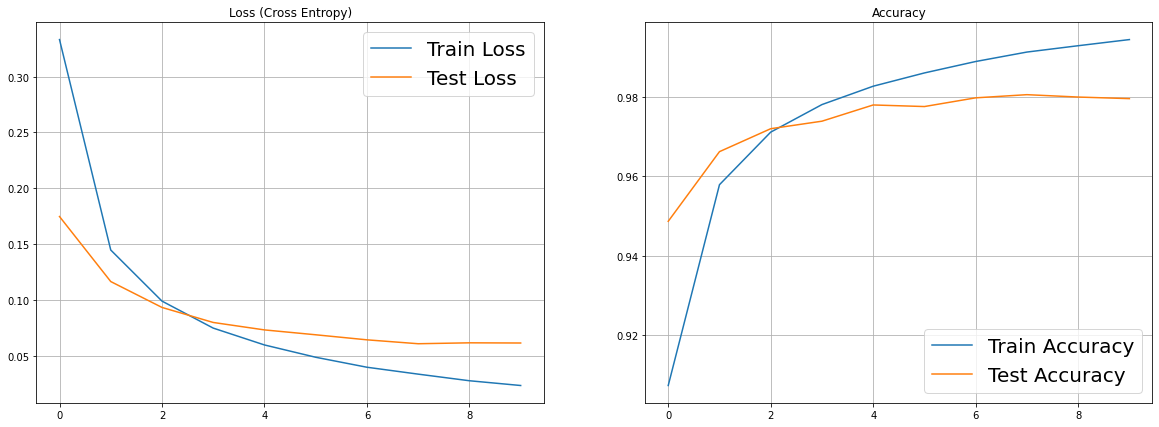

In [25]:
HISTORY = collections.defaultdict(list)

### YOUR SOLUTION ###

NUM_EPOCH = 10
# DEVICE = torch.device("cpu")
DEVICE = torch.device("cuda:0")

mlp_model.to(DEVICE)

for epoch in range(NUM_EPOCH):
    # AverageMeter will accumulate average of some metric
    # Procceed to `utils.py` to see implementation
    train_loss_meter = AverageMeter()
    train_accuracy_meter = AverageMeter()
    test_loss_meter = AverageMeter()
    test_accuracy_meter = AverageMeter()

    # training loop
    for train_batch in train_dataloader:
        # unpack batch and move to specific device (for example, GPU or TPU)
        images, labels = train_batch
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        ### YOUR SOLUTION ###
        # do forward pass
        # calculate loss (CrossEntropy)
        # zero out the previous gradients of our model parameters
        # calculate new gradients
        # do optimization step
        optimizer.zero_grad()
        logits = mlp_model(images.reshape(images.shape[0], -1))
        prediction = logits.argmax(dim=-1)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        # calculate current average loss and accuracy
        train_loss_meter.update(loss.item())
        train_accuracy_meter.update(calculate_accuracy(prediction.detach(), labels).item())

    # save average train loss and accuracy
    HISTORY["train_loss"].append(train_loss_meter.avg)
    HISTORY["train_accuracy"].append(train_accuracy_meter.avg)

    # testing loop
    for test_batch in test_dataloader:
        images, labels = test_batch
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # аdd `with torch.no_grad()' to avoid computing gradients of weights
        with torch.no_grad():
            # do everything like we did in training loop
            logits = mlp_model(images.reshape(images.shape[0], -1))
            prediction = logits.argmax(dim=-1)
            loss = criterion(logits, labels)

        test_loss_meter.update(loss.item())
        test_accuracy_meter.update(calculate_accuracy(prediction, labels).item())

    # save average test accuracy loss and accuracy
    HISTORY["test_loss"].append(test_loss_meter.avg)
    HISTORY["test_accuracy"].append(test_accuracy_meter.avg)

    # visualize all together
    display.clear_output()
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))
    axes[0].set_title("Loss (Cross Entropy)")
    axes[0].plot(HISTORY["train_loss"], label="Train Loss")
    axes[0].plot(HISTORY["test_loss"], label="Test Loss")
    axes[0].grid()
    axes[0].legend(fontsize=20)

    axes[1].set_title("Accuracy")
    axes[1].plot(HISTORY["train_accuracy"], label="Train Accuracy")
    axes[1].plot(HISTORY["test_accuracy"], label="Test Accuracy")
    axes[1].grid()
    axes[1].legend(fontsize=20)

    plt.show()

In [26]:
ans_part2 = HISTORY['test_accuracy'][-1]